In [19]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

In [20]:
print(TRAIN_DATA, TRAIN_LABELS)

[[4.46106157 4.08407045]
 [1.63362818 4.52389342]
 [1.13097336 0.9424778 ]
 [5.34070751 1.31946891]
 [1.31946891 3.83274304]
 [5.71769863 3.51858377]
 [5.96902604 5.34070751]
 [2.51327412 0.06283185]
 [6.22035345 4.27256601]
 [2.89026524 4.96371639]
 [5.90619419 2.07345115]
 [3.33008821 2.38761042]
 [1.25663706 4.08407045]
 [2.95309709 5.02654825]
 [4.77522083 0.25132741]
 [2.89026524 2.136283  ]
 [4.90088454 5.84336234]
 [2.76460154 2.136283  ]
 [3.0787608  4.64955713]
 [1.82212374 6.22035345]
 [3.83274304 5.2150438 ]
 [0.06283185 1.44513262]
 [3.58141563 1.82212374]
 [3.76991118 6.1575216 ]
 [3.45575192 1.25663706]
 [2.32477856 2.89026524]
 [4.52389342 0.62831853]
 [3.58141563 0.18849556]
 [2.45044227 1.13097336]
 [0.25132741 4.58672527]
 [4.90088454 0.9424778 ]
 [2.57610598 2.89026524]
 [3.89557489 4.1469023 ]
 [1.75929189 5.27787566]
 [5.65486678 4.96371639]
 [4.20973416 2.89026524]
 [3.83274304 5.2150438 ]
 [1.44513262 2.70176968]
 [2.45044227 6.03185789]
 [2.57610598 3.0787608 ]]

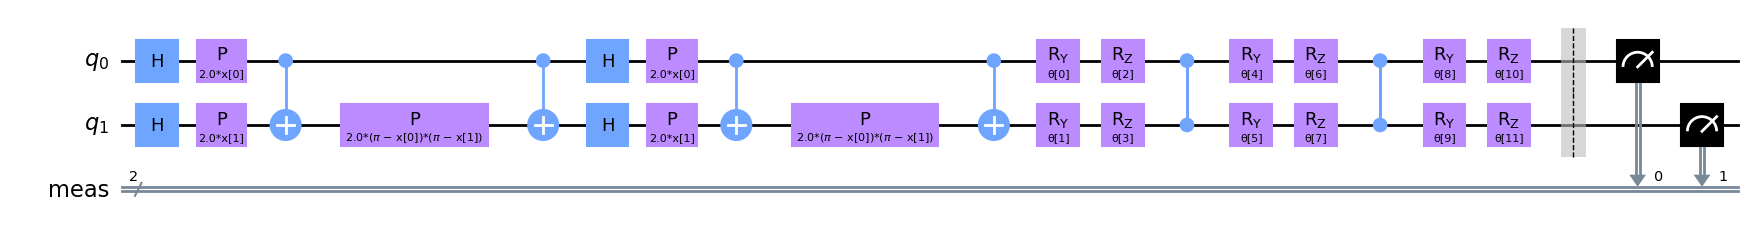

In [21]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

In [22]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [23]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

In [24]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [25]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

In [26]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

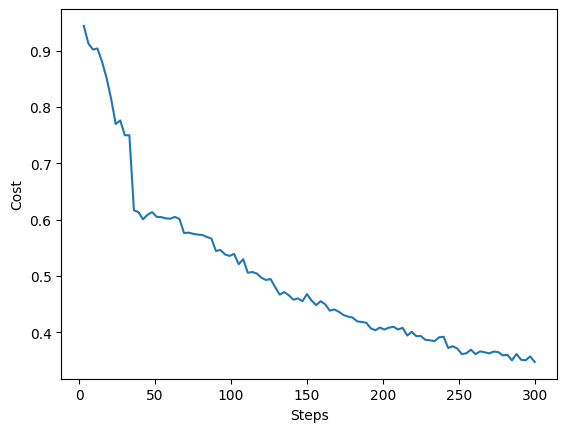

In [27]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()